# Time Series Examples

+ Using ETF intraday data.

### Packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from mlutils import run_adf_test, auto_arima

### Data
Load the ETF one-minute table from the 'data' folder.  
Make 'time' column to have datetime dtype. Keep 'date' and 'sym' as string dtype.  
Display unique dates and symbols.

In [2]:
datapath = '../Data/etf-1min-201806.csv'
cols = ['date','time','sym','volume','vwap','lowPx','highPx','lastPx','lastBidPx','lastAskPx','lastBidSz','lastAskSz']
etfs = pd.read_csv(datapath, usecols=cols, parse_dates={'tstamp':['date', 'time']}, keep_date_col=True)
etfs = etfs.drop(columns='time').rename(columns={'tstamp':'time'})
print('dates:', etfs.date.unique())
print('symbols:', etfs.sym.unique())

dates: ['2018-06-04' '2018-06-05' '2018-06-06' '2018-06-07' '2018-06-08'
 '2018-06-11' '2018-06-12' '2018-06-13' '2018-06-14' '2018-06-15'
 '2018-06-18' '2018-06-19' '2018-06-20' '2018-06-21' '2018-06-22'
 '2018-06-25' '2018-06-26' '2018-06-27' '2018-06-28' '2018-06-29']
symbols: ['SPY' 'XLB' 'XLE' 'XLF' 'XLI' 'XLK' 'XLP' 'XLU' 'XLV' 'XLY']


Select data for one trading day and one symbol

In [3]:
adate = '2018-06-29'
sym = 'SPY'
etf1d = etfs[(etfs.date == adate) & (etfs.sym == sym)]
display(etf1d.head(5))
display(etf1d.tail(5))

,time,date,sym,volume,vwap,lowPx,highPx,lastPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
74100,2018-06-29 09:30:00,2018-06-29,SPY,767092,272.1819,272.08,272.38,272.37,272.37,272.38,5,12
74101,2018-06-29 09:31:00,2018-06-29,SPY,264162,272.3575,272.29,272.40,272.38,272.36,272.37,4,4
74102,2018-06-29 09:32:00,2018-06-29,SPY,291628,272.3700,272.32,272.43,272.34,272.34,272.35,7,100
74103,2018-06-29 09:33:00,2018-06-29,SPY,320010,272.3188,272.20,272.41,272.30,272.30,272.31,4,2
74104,2018-06-29 09:34:00,2018-06-29,SPY,139434,272.3615,272.08,272.43,272.38,272.38,272.39,120,20


,time,date,sym,volume,vwap,lowPx,highPx,lastPx,lastBidPx,lastAskPx,lastBidSz,lastAskSz
74485,2018-06-29 15:55:00,2018-06-29,SPY,1252484,271.7408,271.65,271.8200,271.770,271.76,271.77,27,29
74486,2018-06-29 15:56:00,2018-06-29,SPY,754100,271.6954,271.61,271.7800,271.660,271.66,271.67,15,106
74487,2018-06-29 15:57:00,2018-06-29,SPY,1512242,271.5502,271.50,271.7365,271.505,271.50,271.51,29,26
74488,2018-06-29 15:58:00,2018-06-29,SPY,1559419,271.5452,271.49,271.6300,271.510,271.50,271.51,4,96
74489,2018-06-29 15:59:00,2018-06-29,SPY,5041955,271.3263,271.19,271.5400,271.190,271.19,271.20,2,1135


## Computation of Returns

Call $P_t$ the lastPx for each minute $t$. We compute simple period returns as $r_t = P_t/P_{t-1}-1$ and log returns as $\log(P_t) - \log(P_{t-1})$.  
Then we turn the returns into basis points and add them as new columns to the data frame.  
We drop the first row because it contains NaN returns

In [4]:
# compute returns and safe assign them
etf1d = etf1d.assign(retBps=10000 * (etf1d.lastPx / etf1d.lastPx.shift() - 1))
etf1d = etf1d.assign(dlogBps=10000 * np.insert(np.diff(np.log(etf1d.lastPx)), 0, np.NaN))
# add a 10-min rolling price average
etf1d = etf1d.assign(r10uPx = etf1d['lastPx'].rolling(window=10, center=False).mean())
# remove the top row so that there are no NaN returns
# keep only relevant columns
etf1dr = etf1d.iloc[1:].loc[:, ['time', 'date', 'sym', 'lastPx', 'r10uPx', 'retBps', 'dlogBps']]
etf1dr.head(12)

,time,date,sym,lastPx,r10uPx,retBps,dlogBps
74101,2018-06-29 09:31:00,2018-06-29,SPY,272.3800,NaN,0.367148,0.367141
74102,2018-06-29 09:32:00,2018-06-29,SPY,272.3400,NaN,-1.468537,-1.468644
74103,2018-06-29 09:33:00,2018-06-29,SPY,272.3000,NaN,-1.468752,-1.468860
74104,2018-06-29 09:34:00,2018-06-29,SPY,272.3800,NaN,2.937936,2.937505
74105,2018-06-29 09:35:00,2018-06-29,SPY,272.4500,NaN,2.569939,2.569609
74106,2018-06-29 09:36:00,2018-06-29,SPY,272.3700,NaN,-2.936319,-2.936750
74107,2018-06-29 09:37:00,2018-06-29,SPY,272.4697,NaN,3.660462,3.659792
74108,2018-06-29 09:38:00,2018-06-29,SPY,272.6100,NaN,5.149196,5.147871
74109,2018-06-29 09:39:00,2018-06-29,SPY,272.5900,272.42597,-0.733649,-0.733676
74110,2018-06-29 09:40:00,2018-06-29,SPY,272.6400,272.45297,1.834257,1.834088


### Time Plots

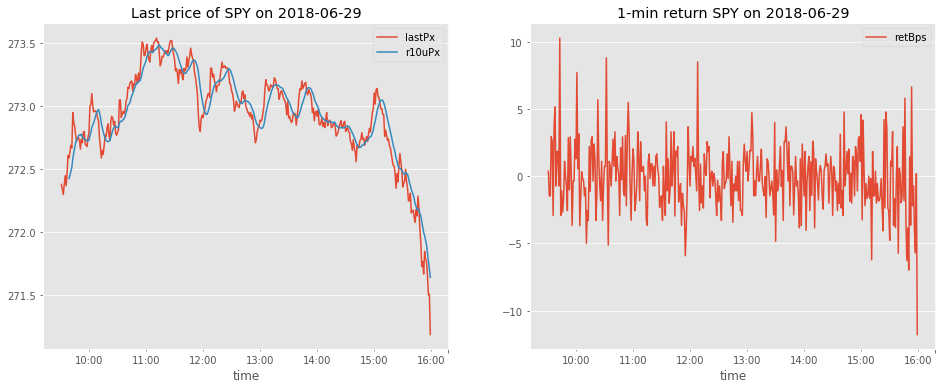

In [5]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
etf1dr.plot(x='time', y='lastPx', ax=ax1, title='Last price of ' + sym + ' on ' + str(adate))
etf1dr.plot(x='time', y='r10uPx', ax=ax1)
ax2 = fig.add_subplot(122)
etf1dr.plot(x='time', y='retBps', ax=ax2, title='1-min return ' + sym + ' on ' + str(adate));


## Tests for Stationarity

We use the Augmented Dickey-Fuller test on prices and returns.

In [6]:
run_adf_test(etf1dr.lastPx)

statistic               1.031741
p-value                 0.994590
n_lags                  4.000000
n_obs                 384.000000
critical_Val (1%)      -3.447495
critical_Val (5%)      -2.869096
critical_Val (10%)     -2.570795
dtype: float64


ADF on prices does not reject non-stationarity at 1% confidence level.

In [7]:
run_adf_test(etf1dr.retBps)

statistic            -1.205721e+01
p-value               2.517377e-22
n_lags                1.000000e+00
n_obs                 3.870000e+02
critical_Val (1%)    -3.447361e+00
critical_Val (5%)    -2.869037e+00
critical_Val (10%)   -2.570764e+00
dtype: float64


ADF on returns rejects non-stationarity at 1% confidence level; the data could be stationary.

## ACF/PACF

Using the StatsModels plotting functions plot_acf and plot_pacf.

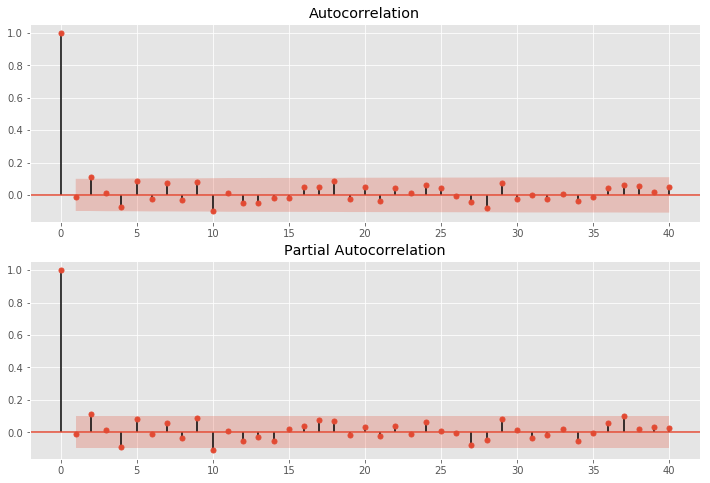

In [8]:
fig2 = plt.figure(figsize=(12, 8))
axx1 = fig2.add_subplot(211)
fig2 = sm.graphics.tsa.plot_acf(etf1dr.retBps.values, lags=40, ax=axx1)
axx2 = fig2.add_subplot(212)
fig2 = sm.graphics.tsa.plot_pacf(etf1dr.retBps.values, lags=40, ax=axx2)

We do not see strong AR or MA signature.

## ARIMA Model Fitting

Using our utility function to find the best ARIMA model

In [9]:
best_arima, results = auto_arima(etf1dr.dlogBps.values, p_max = 2, q_max = 2, verbose=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

ARIMA(0, 0, 0) AIC:1811.40  BIC:1819.32
ARIMA(0, 0, 1) AIC:1813.34  BIC:1825.23
ARIMA(0, 0, 2) AIC:1809.39  BIC:1825.24
ARIMA(0, 1, 0) AIC:2070.46  BIC:2078.38
ARIMA(0, 1, 1) AIC:1806.71  BIC:1818.60
ARIMA(0, 1, 2) AIC:1808.39  BIC:1824.23
ARIMA(1, 0, 0) AIC:1813.33  BIC:1825.22
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
ARIMA(1, 1, 0) AIC:1929.56  BIC:1941.44
ARIMA(1, 1, 1) AIC:1808.32  BIC:1824.16


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 1, 2) AIC:1809.61  BIC:1829.42
ARIMA(2, 0, 0) AIC:1810.35  BIC:1826.21
ARIMA(2, 0, 1) AIC:1812.32  BIC:1832.14
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARIMA(2, 1, 0) AIC:1895.75  BIC:1911.60
ARIMA(2, 1, 1) AIC:1806.75  BIC:1826.56
SVD did not converge
Best model params:(0, 1, 1) AIC:1806.71  BIC:1818.60


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


We print summary of the best selected model, based on the AIC criterion.

In [10]:
best_arima['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  388
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -900.356
Method:                       css-mle   S.D. of innovations              2.445
Date:                Wed, 03 Apr 2019   AIC                           1806.713
Time:                        20:44:51   BIC                           1818.596
Sample:                             1   HQIC                          1811.424
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.001     -3.017      0.003      -0.005      -0.001
ma.L1.D.y     -1.0000      0.009   -114.803      0.000      -1.017      -0.983
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

We plot actual and fitted returns.

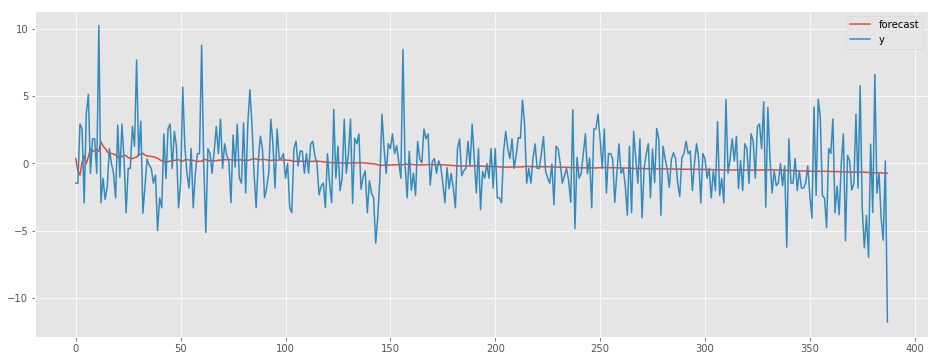

In [11]:
armodel = best_arima['model']

fig2 = plt.figure(figsize=(16,6))
axx = fig2.add_subplot(111)
armodel.plot_predict(ax = axx);

## Analysis of Residuals

We check if the residuals are normal.  
For this we use the Jarque-Bera test for normality.  
This is available via the sm.stats.jarque_bera function.

In [12]:
arresid = armodel.resid 
jbres = sm.stats.jarque_bera(arresid)

print("Jarque-Bera Normality Test on AR Residuals")
print("statistic: {}".format(jbres[0]))
print("p-value: {}".format(jbres[1]))
print('skew: {}'.format(jbres[2]))
print('kurtosis: {}'.format(jbres[3]))

Jarque-Bera Normality Test on AR Residuals
statistic: 47.38710318636265
p-value: 5.128865218554817e-11
skew: 0.17064517062911008
kurtosis: 4.677701381295465


The residuals are skewed to the right and are leptokurtic (fat tails).  
The qq-plot shows this large deviation from normality.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


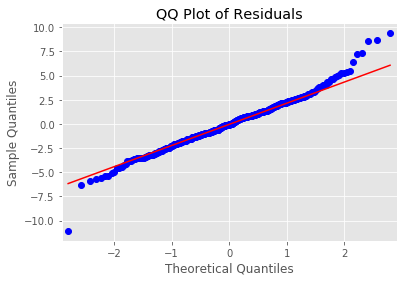

In [13]:
axxx = plt.figure().add_subplot(111)
sm.graphics.qqplot(arresid, line='q', ax = axxx);
axxx.set(title = 'QQ Plot of Residuals');

Intraday returns are non-normal.  We need to go beyond simple AR models.